In [1]:
%run PreProcessing.ipynb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import *
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

Current Progress: 100.0 %


In [2]:
summary_data_avg['harvest_timing'] = 'late'
summary_data_avg.loc[summary_data_avg['mean_diameter'] < 34, 'harvest_timing'] = 'optimal'
summary_data_avg.loc[summary_data_avg['mean_diameter'] < 29, 'harvest_timing'] = 'suitable'
summary_data_avg.loc[summary_data_avg['mean_diameter'] < 24, 'harvest_timing'] = 'early'

In [3]:
enc = OrdinalEncoder()
encoded_df = enc.fit_transform(summary_data_avg[['method', 'variety', 'inputs', 'protection']])
summary_data_avg[['method', 'variety', 'inputs', 'protection']] = encoded_df

In [4]:
X = summary_data_avg[['heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']]
print(X.head())
y = summary_data_avg['harvest_timing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10, stratify = y)

   heat_units  solar_radiation  organic_matter  sand  silt  clay  method  \
0        1970          1073585            24.6    40    41    19     2.0   
1        2641          1247965            24.6    40    41    19     2.0   
2        3189          1379555            24.6    40    41    19     2.0   
3        3540          1529793            24.6    40    41    19     2.0   
4        1970          1073585            24.6    40    41    19     2.0   

   variety  inputs  protection  
0     11.0     1.0         0.0  
1     11.0     1.0         0.0  
2     11.0     1.0         0.0  
3     11.0     1.0         0.0  
4     11.0     1.0         0.0  


In [5]:
print(y_train.value_counts())

early       1892
suitable     494
optimal      157
late          14
Name: harvest_timing, dtype: int64


In [6]:
#Isolation forest algorithm to show unsupervised learning
from sklearn.ensemble import IsolationForest

print(f"The old training dataframe shape: {X_train.shape}")

#Use the algorithm for outlier detection, then use it to predict each point
clf1 = IsolationForest(max_samples=500, random_state = 10, contamination= 'auto')
preds = clf1.fit_predict(X_train)

#Any point labelled as -1 is an outlier
totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

The old training dataframe shape: (2557, 10)
Total number of outliers identified is:  732


In [7]:
#Remove outliers from training data.
filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The new training dataframe shape: (1825, 10)


In [8]:
print(y_train.value_counts())

early       1310
suitable     382
optimal      125
late           8
Name: harvest_timing, dtype: int64


In [9]:
from sklearn.utils import resample

chosen_feat_list = list(X_train)

train_df = pd.merge(X_train, y_train, right_index=True, left_index=True)

early_df = train_df[train_df['harvest_timing']=='early']
suitable_df = train_df[train_df['harvest_timing']=='suitable']
optimal_df = train_df[train_df['harvest_timing']=='optimal']
late_df = train_df[train_df['harvest_timing']=='late']

n = 500

early_resampled = resample(early_df, replace=True, n_samples=n, random_state=10)
suitable_resampled = resample(suitable_df, replace=True, n_samples=n, random_state=10)
optimal_resampled = resample(optimal_df, replace=True, n_samples=n, random_state=10)
late_resampled = resample(late_df, replace=True, n_samples=n, random_state=10)

train_df_resampled = pd.concat([early_resampled, suitable_resampled, optimal_resampled, late_resampled], ignore_index=True)

X_train = train_df_resampled[chosen_feat_list]
y_train = train_df_resampled['harvest_timing']

print(y_train.value_counts())

suitable    500
optimal     500
early       500
late        500
Name: harvest_timing, dtype: int64


In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'criterion': 'entropy', 'max_features': 'auto', 'random_state': 11, 'splitter': 'best'}
              precision    recall  f1-score   support

       early       0.95      0.87      0.91       474
        late       0.33      0.67      0.44         3
     optimal       0.44      0.62      0.51        39
    suitable       0.56      0.65      0.60       124

    accuracy                           0.81       640
   macro avg       0.57      0.70      0.62       640
weighted avg       0.84      0.81      0.82       640



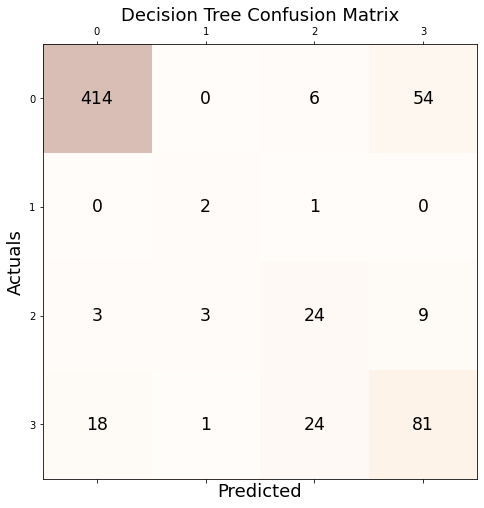

In [11]:
param_grid = {'criterion': ['gini', 'entropy'],  
              'splitter': ['best', 'random'], 
              'random_state': [11],
              'max_features': [None, 'auto']}  
   
grid_dtc = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid_dtc.fit(X_train_scaled, y_train.values.ravel()) 
 
# print best parameter after tuning 
print(grid_dtc.best_params_) 
grid_dtc_preds = grid_dtc.predict(X_test_scaled) 
   
# print classification report 
print(classification_report(y_test, grid_dtc_preds, zero_division = 0)) 

conf_matrix = confusion_matrix(y_test, grid_dtc_preds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Decision Tree Confusion Matrix', fontsize=18)
plt.show()

dtc = DecisionTreeClassifier(criterion = 'gini', random_state = 11, max_features = None, splitter = 'best')
dtc_model = dtc.fit(X_train_scaled, y_train.values.ravel())
dtc_model_pred = dtc_model.predict(X_test_scaled)
dtc_accuracy = accuracy_score(y_test, dtc_model_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'auto', 'random_state': 10}
              precision    recall  f1-score   support

       early       0.96      0.90      0.93       474
        late       0.40      0.67      0.50         3
     optimal       0.42      0.64      0.51        39
    suitable       0.59      0.63      0.61       124

    accuracy                           0.83       640
   macro avg       0.59      0.71      0.64       640
weighted avg       0.85      0.83      0.84       640



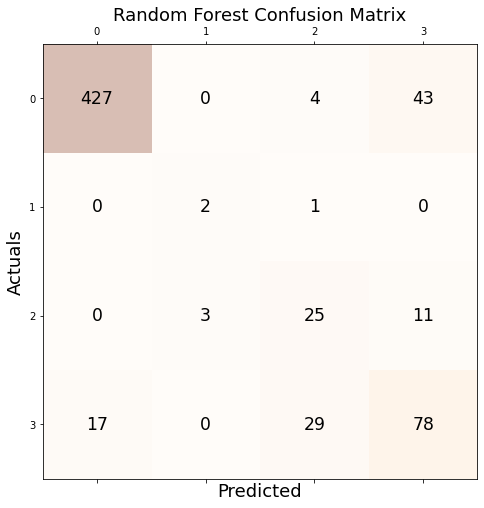

In [12]:
param_grid = {'criterion': ['gini', 'entropy'],  
              'class_weight': [None, 'balanced_subsample'], 
              'random_state': [10],
              'max_features': ['auto', 'sqrt', 'log2']}  
   
grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid_rfc.fit(X_train_scaled, y_train.values.ravel()) 
 
# print best parameter after tuning 
print(grid_rfc.best_params_) 
grid_rfc_preds = grid_rfc.predict(X_test_scaled) 
   
# print classification report 
print(classification_report(y_test, grid_rfc_preds, zero_division = 0)) 

conf_matrix = confusion_matrix(y_test, grid_rfc_preds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Random Forest Confusion Matrix', fontsize=18)
plt.show()

rfc = RandomForestClassifier(criterion = 'gini', class_weight = 'balanced_subsample', random_state = 10, max_features = 'auto')
rfc_model = rfc.fit(X_train_scaled, y_train.values.ravel())
rfc_model_pred = rfc_model.predict(X_test_scaled)
rfc_accuracy = accuracy_score(y_test, rfc_model_pred)
